<a href="https://colab.research.google.com/github/RecSys-lab/RAG-VisualRec/blob/main/codes/simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/PreferredAI/tutorials/blob/master/recommender-systems/05_multimodality.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/PreferredAI/tutorials/blob/master/recommender-systems/05_multimodality.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## 1. Setup

In [ ]:
!pip install --quiet cornac==1.15.4

In [ ]:
# Imports
import cornac
import numpy as np
import pandas as pd
import requests
from io import StringIO
from cornac.models import VBPR
from cornac.metrics import AUC
from cornac.data import ImageModality
from cornac.eval_methods import RatioSplit
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Set random seed for reproducibility
SEED = 42
rng = np.random.RandomState(SEED)

Loading MovieLens 100K dataset...
Data from http://files.grouplens.org/datasets/movielens/ml-100k/u.data
will be cached into /root/.cornac/ml-100k/u.data


0.00B [00:00, ?B/s]

File cached!
Total interactions: 100000
Sampling 10000 interactions (10.0%)...
After sampling, 905 users and 1243 items remain.
Sampled item-to-index mapping (first 5): [('1', 0), ('10', 1), ('100', 2), ('1000', 3), ('1001', 4)]
Original embeddings data:
   itemId                            title  \
0   80363  Resident Evil: Afterlife (2010)   
1   56145                 Mist, The (2007)   
2    8638             Before Sunset (2004)   
3    1214                     Alien (1979)   
4   97304                      Argo (2012)   

                               genres  \
0  Action|Horror|Sci-Fi|Thriller|IMAX   
1                       Horror|Sci-Fi   
2                       Drama|Romance   
3                       Horror|Sci-Fi   
4                      Drama|Thriller   

                                           embedding  
0  0.274137,0.432131,0.396163,0.074233,0.753928,1...  
1  0.168658,0.309507,0.12551,0.05076,0.332977,1.1...  
2  0.085066,0.297835,0.038887,0.037076,0.247809,0...  
3

Epoch 1/20:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/2 [00:00<?, ?it/s]

Optimization finished!

[VBPR] Evaluation started!


Ranking:   0%|          | 0/14 [00:00<?, ?it/s]


TEST:
...
     |    AUC | Train (s) | Test (s)
---- + ------ + --------- + --------
VBPR | 0.7164 |    1.5245 |   0.1104

Visualizing item embeddings with t-SNE...


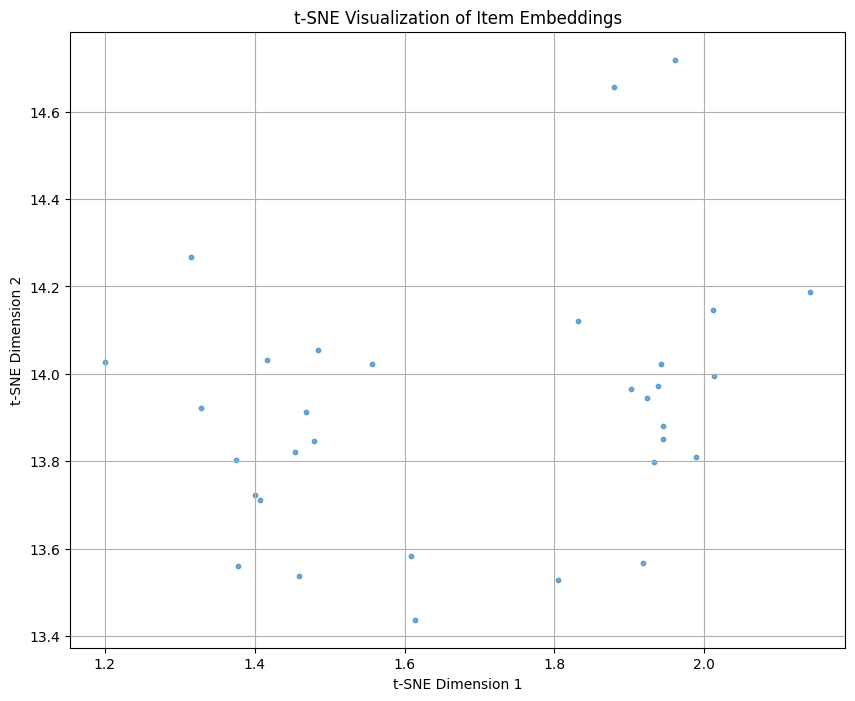

In [ ]:
##############################################################################
# 1) LOAD MOVIELENS 100K FEEDBACK
##############################################################################

print("Loading MovieLens 100K dataset...")
ml100k = cornac.datasets.movielens.load_feedback(variant='100K')

# Convert to DataFrame for easier manipulation
ml100k_df = pd.DataFrame(ml100k, columns=['userId', 'itemId', 'rating'])

# Sample 10% of interactions
sampling_rate = 0.10  # 10%
n_total_interactions = len(ml100k_df)
n_samples = int(n_total_interactions * sampling_rate)

print(f"Total interactions: {n_total_interactions}")
print(f"Sampling {n_samples} interactions ({sampling_rate*100}%)...")

sampled_ml100k_df = ml100k_df.sample(n=n_samples, random_state=SEED).reset_index(drop=True)

# Update n_users and unique_item_ids based on sampled data
unique_user_ids = sorted(sampled_ml100k_df['userId'].unique())
unique_item_ids = sorted(sampled_ml100k_df['itemId'].unique())
n_users = len(unique_user_ids)
n_items = len(unique_item_ids)

print(f"After sampling, {n_users} users and {n_items} items remain.")

# Map item_id <-> index
item_to_index = {iid: idx for idx, iid in enumerate(unique_item_ids)}
print(f"Sampled item-to-index mapping (first 5): {list(item_to_index.items())[:5]}")

##############################################################################
# 2) DOWNLOAD AND LOAD ITEM EMBEDDINGS FROM GOOGLE DRIVE
##############################################################################

print("Downloading item embeddings from Google Drive...")

# Replace this link with your actual Google Drive link
fileLink = 'https://drive.google.com/file/d/1V1y8ivT0s52y8TtVFgoD5OzXwE6yHIbl/view?usp=sharing'

# Extract the file ID from the Google Drive link.
file_id = fileLink.split('/d/')[1].split('/')[0]
download_link = f'https://drive.google.com/uc?id={file_id}&export=download'

# Download the file
response = requests.get(download_link)
response.raise_for_status()  # Ensure the request was successful

# Read the CSV content directly from the response
# Assuming the CSV has columns: 'itemId', 'embedding'
# Where 'embedding' is a string of comma-separated numbers, e.g., "0.1,0.2,0.3,..."
fusedData = pd.read_csv(StringIO(response.text))

print("Original embeddings data:")
print(fusedData.head())

# Ensure the necessary columns are present
assert 'itemId' in fusedData.columns, "The CSV must contain 'itemId' column."
assert 'embedding' in fusedData.columns, "The CSV must contain 'embedding' column."

# Convert the 'embedding' column from string to numpy arrays
# Assuming embeddings are comma-separated floats
fusedData['embedding'] = fusedData['embedding'].apply(
    lambda x: np.array([float(i) for i in x.split(',')])
)

# Ensure embeddings have consistent dimensions
embedding_dims = fusedData['embedding'].apply(len)
if not embedding_dims.nunique() == 1:
    raise ValueError("Inconsistent embedding dimensions found.")

embedding_dim = embedding_dims.iloc[0]
print(f"Embedding dimension: {embedding_dim}")

##############################################################################
# 3) DROP ITEMS WITHOUT EMBEDDINGS
##############################################################################

print("Dropping items without embeddings...")

# Ensure `itemId` in both DataFrames has the same type
fusedData['itemId'] = fusedData['itemId'].astype(str)
sampled_ml100k_df['itemId'] = sampled_ml100k_df['itemId'].astype(str)

# Filter `ml100k` dataset to include only items with embeddings
available_item_ids = set(fusedData['itemId'])
ml100k_df = sampled_ml100k_df[sampled_ml100k_df['itemId'].isin(available_item_ids)]

# Update the list of unique_item_ids and the mapping
unique_item_ids = sorted(ml100k_df['itemId'].unique())
item_to_index = {iid: idx for idx, iid in enumerate(unique_item_ids)}

# Filter and align the embeddings to the remaining items
filtered_fusedData = fusedData[fusedData['itemId'].isin(unique_item_ids)]
filtered_fusedData = filtered_fusedData.set_index('itemId').reindex(unique_item_ids)

# Log missing item IDs
missing_embeddings = set(unique_item_ids) - set(filtered_fusedData.index)
if missing_embeddings:
    print(f"Missing embeddings for item IDs: {missing_embeddings}")

# Ensure no missing embeddings
assert not filtered_fusedData['embedding'].isnull().any(), "There are still missing embeddings after filtering!"

# Extract embeddings into a matrix
features = np.vstack(filtered_fusedData['embedding'].values)
print(f"Final feature matrix shape: {features.shape}")

##############################################################################
# 4) BUILD IMAGEMODALITY OBJECT
##############################################################################

print("Building ImageModality object...")
item_image_modality = ImageModality(
    features=features,
    ids=unique_item_ids,
    normalized=True  # Normalize embeddings if needed
)

##############################################################################
# 5) DEFINE EVALUATION METHOD (RATIO SPLIT FOR RANKING)
##############################################################################

print("Defining RatioSplit for ranking-based evaluation...")

# Convert sampled_ml100k_df back to list of tuples for Cornac
sampled_ml100k = list(ml100k_df.itertuples(index=False, name=None))

ratio_split = RatioSplit(
    data=sampled_ml100k,
    test_size=0.2,
    rating_threshold=4.0,  # Treat ratings >=4 as positive feedback
    exclude_unknowns=True,
    item_image=item_image_modality,
    seed=SEED,
    verbose=True
)

##############################################################################
# 6) INSTANTIATE VBPR MODEL
##############################################################################

print("Instantiating VBPR model...")
vbpr = VBPR(
    k=10,               # Dimension for user/item embeddings
    k2=10,              # Dimension for visual preference embeddings
    n_epochs=20,        # Number of epochs
    batch_size=128,     # Batch size
    learning_rate=0.005, # Learning rate
    lambda_w=0.001,     # Regularization for weights
    lambda_b=0.001,     # Regularization for biases
    lambda_e=0.0,       # Regularization for E matrix
    use_gpu=False,      # Set to True if you have a GPU and compatible setup
    seed=SEED,
    verbose=True
)

##############################################################################
# 7) PICK RANKING METRIC (AUC)
##############################################################################

print("Setting up AUC metric...")
auc = AUC()

##############################################################################
# 8) RUN THE EXPERIMENT
##############################################################################

print("Running the experiment...")
experiment = cornac.Experiment(
    eval_method=ratio_split,
    models=[vbpr],
    metrics=[auc]
)

experiment.run()

##############################################################################
# 9) VISUALIZE ITEM EMBEDDINGS USING t-SNE
##############################################################################

print("Visualizing item embeddings with t-SNE...")

# Fit t-SNE on the item embeddings
tsne = TSNE(n_components=2, random_state=SEED)
embeddings_2d = tsne.fit_transform(features)

# Create a DataFrame for plotting
tsne_df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'itemId': unique_item_ids
})

# Plot the t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(tsne_df['x'], tsne_df['y'], alpha=0.6, s=10)
plt.title('t-SNE Visualization of Item Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()


In [ ]:
!pip install --quiet cornac==1.15.4

##############################################################################
# IMPORTS
##############################################################################

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import requests
from io import StringIO
import cornac
from cornac.data import ImageModality
from cornac.eval_methods import RatioSplit
from cornac.models import VBPR, BPR, MostPop
from cornac.metrics import AUC

# Set random seed for reproducibility
SEED = 42
rng = np.random.RandomState(SEED)
##############################################################################
# 1) LOAD MOVIELENS 100K FEEDBACK
##############################################################################

print("Loading MovieLens 100K dataset...")
ml100k = cornac.datasets.movielens.load_feedback(variant='1M')

# Convert to DataFrame for easier manipulation
ml100k_df = pd.DataFrame(ml100k, columns=['userId', 'itemId', 'rating'])

# Sample 10% of interactions
sampling_rate = 1  # 10%
n_total_interactions = len(ml100k_df)
n_samples = int(n_total_interactions * sampling_rate)

print(f"Total interactions: {n_total_interactions}")
print(f"Sampling {n_samples} interactions ({sampling_rate*100}%)...")

sampled_ml100k_df = ml100k_df.sample(n=n_samples, random_state=SEED).reset_index(drop=True)

# Update n_users and unique_item_ids based on sampled data
unique_user_ids = sorted(sampled_ml100k_df['userId'].unique())
unique_item_ids = sorted(sampled_ml100k_df['itemId'].unique())
n_users = len(unique_user_ids)
n_items = len(unique_item_ids)

print(f"After sampling, {n_users} users and {n_items} items remain.")

# Map item_id <-> index
item_to_index = {iid: idx for idx, iid in enumerate(unique_item_ids)}
print(f"Sampled item-to-index mapping (first 5): {list(item_to_index.items())[:5]}")

##############################################################################
# 2) DOWNLOAD AND LOAD ITEM EMBEDDINGS FROM GOOGLE DRIVE
##############################################################################

print("Downloading item embeddings from Google Drive...")

# Replace this link with your actual Google Drive link
fileLink = 'https://drive.google.com/file/d/1V1y8ivT0s52y8TtVFgoD5OzXwE6yHIbl/view?usp=sharing'

# Extract the file ID from the Google Drive link.
file_id = fileLink.split('/d/')[1].split('/')[0]
download_link = f'https://drive.google.com/uc?id={file_id}&export=download'

# Download the file
response = requests.get(download_link)
response.raise_for_status()  # Ensure the request was successful

# Read the CSV content directly from the response
fusedData = pd.read_csv(StringIO(response.text))

print("Original embeddings data:")
print(fusedData.head())

# Ensure the necessary columns are present
assert 'itemId' in fusedData.columns, "The CSV must contain 'itemId' column."
assert 'embedding' in fusedData.columns, "The CSV must contain 'embedding' column."

# Convert the 'embedding' column from string to numpy arrays
fusedData['embedding'] = fusedData['embedding'].apply(
    lambda x: np.array([float(i) for i in x.split(',')])
)

# Ensure embeddings have consistent dimensions
embedding_dims = fusedData['embedding'].apply(len)
if not embedding_dims.nunique() == 1:
    raise ValueError("Inconsistent embedding dimensions found.")

embedding_dim = embedding_dims.iloc[0]
print(f"Embedding dimension: {embedding_dim}")

##############################################################################
# 3) DROP ITEMS WITHOUT EMBEDDINGS
##############################################################################

print("Dropping items without embeddings...")

# Ensure `itemId` in both DataFrames has the same type
fusedData['itemId'] = fusedData['itemId'].astype(str)
sampled_ml100k_df['itemId'] = sampled_ml100k_df['itemId'].astype(str)

# Filter `ml100k` dataset to include only items with embeddings
available_item_ids = set(fusedData['itemId'])
ml100k_df = sampled_ml100k_df[sampled_ml100k_df['itemId'].isin(available_item_ids)]

# Update the list of unique_item_ids and the mapping
unique_item_ids = sorted(ml100k_df['itemId'].unique())
item_to_index = {iid: idx for idx, iid in enumerate(unique_item_ids)}

# Filter and align the embeddings to the remaining items
filtered_fusedData = fusedData[fusedData['itemId'].isin(unique_item_ids)]
filtered_fusedData = filtered_fusedData.set_index('itemId').reindex(unique_item_ids)

# Log missing item IDs
missing_embeddings = set(unique_item_ids) - set(filtered_fusedData.index)
if missing_embeddings:
    print(f"Missing embeddings for item IDs: {missing_embeddings}")

# Ensure no missing embeddings
assert not filtered_fusedData['embedding'].isnull().any(), "There are still missing embeddings after filtering!"

# Extract embeddings into a matrix
features = np.vstack(filtered_fusedData['embedding'].values)
print(f"Final feature matrix shape: {features.shape}")

##############################################################################
# 4) BUILD IMAGEMODALITY OBJECT
##############################################################################

print("Building ImageModality object...")
item_image_modality = ImageModality(
    features=features,
    ids=unique_item_ids,
    normalized=True  # Normalize embeddings if needed
)

random_features = np.random.rand(len(unique_item_ids), embedding_dim)
random_item_image_modality = ImageModality(
    features=random_features,
    ids=unique_item_ids,
    normalized=True
)

##############################################################################
# 5) DEFINE EVALUATION METHOD (RATIO SPLIT FOR RANKING)
##############################################################################

print("Defining RatioSplit for ranking-based evaluation...")

# Convert sampled_ml100k_df back to list of tuples for Cornac
sampled_ml100k = list(ml100k_df.itertuples(index=False, name=None))

ratio_split = RatioSplit(
    data=sampled_ml100k,
    test_size=0.2,
    rating_threshold=4.0,  # Treat ratings >=4 as positive feedback
    exclude_unknowns=True,
    item_image=item_image_modality,
    seed=SEED,
    verbose=True
)

random_ratio_split = RatioSplit(
    data=sampled_ml100k,
    test_size=0.2,
    rating_threshold=4.0,
    exclude_unknowns=True,
    item_image=random_item_image_modality,
    seed=SEED,
    verbose=True
)

##############################################################################
# 6) INSTANTIATE MODELS
##############################################################################

print("Instantiating models...")

# VBPR (original)
vbpr = VBPR(
    k=10,
    k2=10,
    n_epochs=20,
    batch_size=128,
    learning_rate=0.005,
    lambda_w=0.001,
    lambda_b=0.001,
    lambda_e=0.0,
    use_gpu=False,
    seed=SEED,
    verbose=True,
    name="VBPR Original"
)

# VBPR Random (random features)
vbpr_random = VBPR(
    k=10,
    k2=10,
    n_epochs=20,
    batch_size=128,
    learning_rate=0.005,
    lambda_w=0.001,
    lambda_b=0.001,
    lambda_e=0.0,
    use_gpu=False,
    seed=SEED,
    verbose=True,
    name="VBPR Random"
)

# BPR
bpr = BPR(k=10, max_iter=20, learning_rate=0.005, lambda_reg=0.001, seed=SEED, verbose=True)

# Most Popular
most_pop = MostPop()

##############################################################################
# 7) PICK RANKING METRIC (AUC)
##############################################################################

print("Setting up AUC metric...")
auc = AUC()

##############################################################################
# 8) RUN THE EXPERIMENT
##############################################################################

print("Running the experiment...")
experiment = cornac.Experiment(
    eval_method=ratio_split,
    models=[vbpr, bpr, most_pop],
    metrics=[auc]
)

experiment_random = cornac.Experiment(
    eval_method=random_ratio_split,
    models=[vbpr_random],
    metrics=[auc]
)

experiment.run()
experiment_random.run()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 41.1 MB/s eta 0:00:00
Loading MovieLens 100K dataset...
Data from http://files.grouplens.org/datasets/movielens/ml-1m.zip
will be cached into /root/.cornac/ml-1m/ratings.dat


0.00B [00:00, ?B/s]

Unzipping ...
File cached!
Total interactions: 1000209
Sampling 1000209 interactions (100%)...
After sampling, 6040 users and 3706 items remain.
Sampled item-to-index mapping (first 5): [('1', 0), ('10', 1), ('100', 2), ('1000', 3), ('1002', 4)]
Original embeddings data:
   itemId                            title  \
0   80363  Resident Evil: Afterlife (2010)   
1   56145                 Mist, The (2007)   
2    8638             Before Sunset (2004)   
3    1214                     Alien (1979)   
4   97304                      Argo (2012)   

                               genres  \
0  Action|Horror|Sci-Fi|Thriller|IMAX   
1                       Horror|Sci-Fi   
2                       Drama|Romance   
3                       Horror|Sci-Fi   
4                      Drama|Thriller   

                                           embedding  
0  0.274137,0.432131,0.396163,0.074233,0.753928,1...  
1  0.168658,0.309507,0.12551,0.05076,0.332977,1.1...  
2  0.085066,0.297835,0.038887,0.037076,

Epoch 1/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/503 [00:00<?, ?it/s]

Optimization finished!

[VBPR Original] Evaluation started!


Ranking:   0%|          | 0/4602 [00:00<?, ?it/s]


[BPR] Training started!


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!

[BPR] Evaluation started!


Ranking:   0%|          | 0/4602 [00:00<?, ?it/s]


[MostPop] Training started!

[MostPop] Evaluation started!


Ranking:   0%|          | 0/4602 [00:00<?, ?it/s]


TEST:
...
              |    AUC | Train (s) | Test (s)
------------- + ------ + --------- + --------
VBPR Original | 0.7441 |  217.7195 |   3.6521
BPR           | 0.7411 |    0.4828 |   1.8133
MostPop       | 0.7413 |    0.0124 |   1.0879


[VBPR Random] Training started!


Epoch 1/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/503 [00:00<?, ?it/s]

Optimization finished!

[VBPR Random] Evaluation started!


Ranking:   0%|          | 0/4602 [00:00<?, ?it/s]


TEST:
...
            |    AUC | Train (s) | Test (s)
----------- + ------ + --------- + --------
VBPR Random | 0.7362 |  194.3024 |   1.7923



# Cold Start Simulation

In [ ]:
!pip install --quiet cornac==1.15.4

##############################################################################
# IMPORTS
##############################################################################

import numpy as np
import pandas as pd
import requests
from io import StringIO
import cornac
from cornac.data import ImageModality
from cornac.eval_methods import RatioSplit
from cornac.models import VBPR, BPR, MostPop, VMF, AMR
from cornac.metrics import AUC, Precision, Recall, NDCG, AUC, MAP

# Set random seed for reproducibility
SEED = 42
rng = np.random.RandomState(SEED)

##############################################################################
# 1) LOAD MOVIELENS 1M FEEDBACK WITH WARM ITEM SAMPLING
##############################################################################

print("Loading MovieLens 1M dataset...")
ml1m = cornac.datasets.movielens.load_feedback(variant='1M')

# Convert to DataFrame for easier manipulation
ml1m_df = pd.DataFrame(ml1m, columns=['userId', 'itemId', 'rating'])

# Identify warm items (items with high interaction count)
item_interaction_counts = ml1m_df['itemId'].value_counts()
warm_item_threshold = item_interaction_counts.quantile(0.8)  # Top 30% most interacted items
warm_items = item_interaction_counts[item_interaction_counts >= warm_item_threshold].index

# Remove a percentage of warm items
warm_removal_percentage = 0.001  # Remove 30% of warm items
num_warm_items_to_remove = int(len(warm_items) * warm_removal_percentage)
warm_items_to_remove = rng.choice(warm_items, num_warm_items_to_remove, replace=False)

print(f"Identified {len(warm_items)} warm items. Removing {num_warm_items_to_remove} warm items...")

ml1m_df = ml1m_df[~ml1m_df['itemId'].isin(warm_items_to_remove)]

# Update interaction data after removing warm items
n_total_interactions = len(ml1m_df)
n_samples = int(n_total_interactions * 1)  # Sample 10% of interactions

print(f"Total interactions after warm item removal: {n_total_interactions}")
print(f"Sampling {n_samples} interactions...")

sampled_ml1m_df = ml1m_df.sample(n=n_samples, random_state=SEED).reset_index(drop=True)

# Update n_users and unique_item_ids based on sampled data
unique_user_ids = sorted(sampled_ml1m_df['userId'].unique())
unique_item_ids = sorted(sampled_ml1m_df['itemId'].unique())
n_users = len(unique_user_ids)
n_items = len(unique_item_ids)

print(f"After sampling, {n_users} users and {n_items} items remain.")

# Map item_id <-> index
item_to_index = {iid: idx for idx, iid in enumerate(unique_item_ids)}
print(f"Sampled item-to-index mapping (first 5): {list(item_to_index.items())[:5]}")

##############################################################################
# 2) DOWNLOAD AND LOAD ITEM EMBEDDINGS FROM GOOGLE DRIVE
##############################################################################

print("Downloading item embeddings from Google Drive...")

# Replace this link with your actual Google Drive link
fileLink = 'https://drive.google.com/file/d/1V1y8ivT0s52y8TtVFgoD5OzXwE6yHIbl/view?usp=sharing' #full-movie mean

# Extract the file ID from the Google Drive link.
file_id = fileLink.split('/d/')[1].split('/')[0]
download_link = f'https://drive.google.com/uc?id={file_id}&export=download'

# Download the file
response = requests.get(download_link)
response.raise_for_status()  # Ensure the request was successful

# Read the CSV content directly from the response
fusedData = pd.read_csv(StringIO(response.text))

print("Original embeddings data:")
print(fusedData.head())

# Ensure the necessary columns are present
assert 'itemId' in fusedData.columns, "The CSV must contain 'itemId' column."
assert 'embedding' in fusedData.columns, "The CSV must contain 'embedding' column."

# Convert the 'embedding' column from string to numpy arrays
fusedData['embedding'] = fusedData['embedding'].apply(
    lambda x: np.array([float(i) for i in x.split(',')])
)

# Ensure embeddings have consistent dimensions
embedding_dims = fusedData['embedding'].apply(len)
if not embedding_dims.nunique() == 1:
    raise ValueError("Inconsistent embedding dimensions found.")

embedding_dim = embedding_dims.iloc[0]
print(f"Embedding dimension: {embedding_dim}")

##############################################################################
# 3) DROP ITEMS WITHOUT EMBEDDINGS
##############################################################################

print("Dropping items without embeddings...")

# Ensure `itemId` in both DataFrames has the same type
fusedData['itemId'] = fusedData['itemId'].astype(str)
sampled_ml1m_df['itemId'] = sampled_ml1m_df['itemId'].astype(str)

# Filter `ml1m` dataset to include only items with embeddings
available_item_ids = set(fusedData['itemId'])
ml1m_df = sampled_ml1m_df[sampled_ml1m_df['itemId'].isin(available_item_ids)]

# Update the list of unique_item_ids and the mapping
unique_item_ids = sorted(ml1m_df['itemId'].unique())
item_to_index = {iid: idx for idx, iid in enumerate(unique_item_ids)}

# Filter and align the embeddings to the remaining items
filtered_fusedData = fusedData[fusedData['itemId'].isin(unique_item_ids)]
filtered_fusedData = filtered_fusedData.set_index('itemId').reindex(unique_item_ids)

# Extract embeddings into a matrix
features = np.vstack(filtered_fusedData['embedding'].values)
print(f"Final feature matrix shape: {features.shape}")

##############################################################################
# 4) BUILD IMAGEMODALITY OBJECT
##############################################################################

print("Building ImageModality object...")
item_image_modality = ImageModality(
    features=features,
    ids=unique_item_ids,
    normalized=True  # Normalize embeddings if needed
)

random_features = np.random.rand(len(unique_item_ids), embedding_dim)
random_item_image_modality = ImageModality(
    features=random_features,
    ids=unique_item_ids,
    normalized=True
)
##############################################################################
# 5) DEFINE EVALUATION METHOD (RATIO SPLIT FOR RANKING)
##############################################################################

print("Defining RatioSplit for ranking-based evaluation...")

# Convert sampled_ml1m_df back to list of tuples for Cornac
sampled_ml1m = list(ml1m_df.itertuples(index=False, name=None))

ratio_split = RatioSplit(
    data=sampled_ml1m,
    test_size=0.2,
    rating_threshold=4.0,  # Treat ratings >=4 as positive feedback
    exclude_unknowns=True,
    item_image=item_image_modality,
    seed=SEED,
    verbose=True
)

random_ratio_split = RatioSplit(
    data=sampled_ml1m,
    test_size=0.2,
    rating_threshold=4.0,
    exclude_unknowns=True,
    item_image=random_item_image_modality,
    seed=SEED,
    verbose=True
)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 16.6 MB/s eta 0:00:00
Loading MovieLens 1M dataset...
Data from http://files.grouplens.org/datasets/movielens/ml-1m.zip
will be cached into /root/.cornac/ml-1m/ratings.dat


0.00B [00:00, ?B/s]

Unzipping ...
File cached!
Identified 743 warm items. Removing 0 warm items...
Total interactions after warm item removal: 1000209
Sampling 1000209 interactions...
After sampling, 6040 users and 3706 items remain.
Sampled item-to-index mapping (first 5): [('1', 0), ('10', 1), ('100', 2), ('1000', 3), ('1002', 4)]
Original embeddings data:
   itemId                            title  \
0   80363  Resident Evil: Afterlife (2010)   
1   56145                 Mist, The (2007)   
2    8638             Before Sunset (2004)   
3    1214                     Alien (1979)   
4   97304                      Argo (2012)   

                               genres  \
0  Action|Horror|Sci-Fi|Thriller|IMAX   
1                       Horror|Sci-Fi   
2                       Drama|Romance   
3                       Horror|Sci-Fi   
4                      Drama|Thriller   

                                           embedding  
0  0.274137,0.432131,0.396163,0.074233,0.753928,1...  
1  0.168658,0.309507,0.12

In [ ]:
##############################################################################
# 6) INSTANTIATE MODELS
##############################################################################

print("Instantiating models...")

vbpr = VBPR(k=4, k2=4, n_epochs=20, batch_size=128, learning_rate=0.005, lambda_w=0.001, lambda_b=0.001, lambda_e=0.0, use_gpu=False, seed=SEED)
bpr = BPR(k=4, max_iter=20, learning_rate=0.005, lambda_reg=0.001, seed=SEED)
most_pop = MostPop()
vmf = VMF(k=4, n_epochs=20, batch_size=128, learning_rate=0.005, lambda_u=0.001, lambda_v=0.001, lambda_e=0.001, use_gpu=False, seed=SEED)
amr = AMR(k=4, k2=4, n_epochs=20, batch_size=128, learning_rate=0.005, lambda_w=0.001, lambda_b=0.001, lambda_e=0.001, use_gpu=False, seed=SEED)
# VBPR Random (random features)
vbpr_random = VBPR(
    k=4,
    k2=4,
    n_epochs=20,
    batch_size=128,
    learning_rate=0.005,
    lambda_w=0.001,
    lambda_b=0.001,
    lambda_e=0.0,
    use_gpu=False,
    seed=SEED,
    verbose=True,
    name="VBPR Random"
)
##############################################################################
# 7) PICK RANKING METRIC (AUC)
##############################################################################

print("Setting up AUC metric...")
auc = AUC()

##############################################################################
# 8) RUN THE EXPERIMENT
##############################################################################

top_k = 5
print("Running the experiment...")
experiment = cornac.Experiment(
    eval_method=ratio_split,
    models=[vbpr, bpr, most_pop, vmf, amr],
    metrics=[Precision(k=top_k), Recall(k=top_k), NDCG(k=top_k), AUC(), MAP()],

)

experiment_random = cornac.Experiment(
    eval_method=random_ratio_split,
    models=[vbpr_random],
    metrics=[Precision(k=top_k), Recall(k=top_k), NDCG(k=top_k), AUC(), MAP()]
)

experiment.run()
#experiment_random.run()

Instantiating models...
Setting up AUC metric...
Running the experiment...

[VBPR] Training started!


Epoch 1/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/503 [00:00<?, ?it/s]

Optimization finished!

[VBPR] Evaluation started!


Ranking:   0%|          | 0/4602 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Ranking:   0%|          | 0/4602 [00:00<?, ?it/s]


[MostPop] Training started!

[MostPop] Evaluation started!


Ranking:   0%|          | 0/4602 [00:00<?, ?it/s]


[VMF] Training started!

[VMF] Evaluation started!


Ranking:   0%|          | 0/4602 [00:00<?, ?it/s]


[AMR] Training started!


Epoch 1/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/503 [00:00<?, ?it/s]

Optimization finished!

[AMR] Evaluation started!


Ranking:   0%|          | 0/4602 [00:00<?, ?it/s]


TEST:
...
        |    AUC |    MAP | NDCG@5 | Precision@5 | Recall@5 | Train (s) | Test (s)
------- + ------ + ------ + ------ + ----------- + -------- + --------- + --------
VBPR    | 0.7930 | 0.1852 | 0.1494 |      0.0953 |   0.2022 |  150.7902 |   5.0814
BPR     | 0.7406 | 0.1776 | 0.1417 |      0.0929 |   0.1789 |    0.2153 |   3.9678
MostPop | 0.7413 | 0.1773 | 0.1409 |      0.0929 |   0.1789 |    0.0013 |   3.0326
VMF     | 0.6834 | 0.1525 | 0.1145 |      0.0755 |   0.1409 |   68.2440 |   3.9652
AMR     | 0.7726 | 0.1936 | 0.1634 |      0.1015 |   0.2103 |  275.6020 |   6.1200

